# Image Captioning with bottom-up and top-down attention

In this example we'll caption an image with the pretrained model.

### 1. Imports and setup

* First, set up Python, `numpy`, and `matplotlib`.
* Then, download pretrained models

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import cv2
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have not set the pythonpath.

from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect,_get_blobs
from fast_rcnn.nms_wrapper import nms

caffe.set_mode_gpu()
caffe.set_device(0)

caffe_root = '../' # this file should be run from REPO_ROOT/scripts

In [2]:
# Reduce the max number of region proposals, so that the bottom-up and top-down models can
# both fit on a 12GB gpu -> this may cause some demo captions to differ slightly from the 
# generated outputs of ./experiments/caption_lstm/train.sh

cfg['TEST']['RPN_POST_NMS_TOP_N'] = 160 # Previously 300 for evaluations reported in the paper

In [3]:
import os
import urllib

rcnn_weights = caffe_root + 'demo/resnet101_faster_rcnn_final.caffemodel'

#caption_weights = caffe_root + 'demo/lstm_iter_60000.caffemodel.h5' # cross-entropy trained
caption_weights = caffe_root + 'demo/lstm_scst_iter_1000.caffemodel.h5' # self-critical trained

if os.path.isfile(rcnn_weights):
    print 'Faster R-CNN weights found.'
else:
    print 'Downloading Faster R-CNN weights...'
    url = "https://storage.googleapis.com/bottom-up-attention/resnet101_faster_rcnn_final.caffemodel"
    urllib.urlretrieve(url, rcnn_weights)

if os.path.isfile(caption_weights):
    print 'Caption weights found.'
else:
    print 'Downloading Caption weights...'
    url = "https://storage.googleapis.com/bottom-up-attention/%s" % caption_weights.split('/')[-1]
    urllib.urlretrieve(url, caption_weights)    
    

Faster R-CNN weights found.
Caption weights found.


### 2. Visualization / feature extraction code for the bottom-up part

In [4]:
# For visualization of bottom-up features

# Load classes
classes = ['__background__']
with open(caffe_root + 'demo/objects_vocab.txt') as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(caffe_root + 'demo/attributes_vocab.txt') as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [5]:
MIN_BOXES = 10
MAX_BOXES = 100

# Code for getting features from Faster R-CNN

def get_detections_from_im(net, cv2_im, image_id, conf_thresh=0.2):
    
    im = cv2_im
    scores, boxes, attr_scores = im_detect(net, im)

    # Keep the original boxes, don't worry about the regresssion bbox outputs
    rois = net.blobs['rois'].data.copy()
    # unscale back to raw image space
    blobs, im_scales = _get_blobs(im, None)

    cls_boxes = rois[:, 1:5] / im_scales[0]
    cls_prob = net.blobs['cls_prob'].data
    attr_prob = net.blobs['attr_prob'].data
    pool5 = net.blobs['pool5_flat'].data   

    # Keep only the best detections
    max_conf = np.zeros((rois.shape[0]))
    for cls_ind in range(1,cls_prob.shape[1]):
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
        keep = np.array(nms(dets, cfg.TEST.NMS))
        max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

    keep_boxes = np.where(max_conf >= conf_thresh)[0]
    if len(keep_boxes) < MIN_BOXES:
        keep_boxes = np.argsort(max_conf)[::-1][:MIN_BOXES]
    elif len(keep_boxes) > MAX_BOXES:
        keep_boxes = np.argsort(max_conf)[::-1][:MAX_BOXES]
    objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
    attrs = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
   
    return {
        'image_id': image_id,
        'image_h': np.size(im, 0),
        'image_w': np.size(im, 1),
        'num_boxes' : len(keep_boxes),
        'boxes': cls_boxes[keep_boxes],
        'features': pool5[keep_boxes],
        'objects': objects,
        'attrs': attrs
    }   

def show_features(boxes, objects, attrs):
    for i in range(boxes.shape[0]):
        bbox = boxes[i]
        if bbox[0] == 0:
            bbox[0] = 1
        if bbox[1] == 0:
            bbox[1] = 1
        cls = classes[objects[i]+1]
        cls = attributes[attrs[i]+1] + " " + cls
        plt.gca().add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.8)
                )
        plt.gca().text(bbox[0], bbox[1] - 2,
                    '%s' % (cls),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=12, color='white')

### 3. Visualization / vocab code for the top-down part

In [6]:
vocab_file = '../data/coco_splits/train_vocab.txt'

vocab = []
with open(vocab_file) as f:
    for word in f:
        vocab.append(word.strip())
print 'Loaded {:,} words into caption vocab'.format(len(vocab))


def translate(vocab, blob):
    caption = "";
    w = 0;
    while True:
        next_word = vocab[int(blob[w])]
        if w == 0:
            next_word = next_word.title()
        if w > 0 and next_word != "." and next_word != ",":
            caption += " ";
        if next_word == "\"" or next_word[0] == '"':
            caption += "\\"; # Escape
        caption += next_word;
        w += 1
        if caption[-1] == '.' or w == len(blob):
            break
    return caption

Loaded 10,010 words into caption vocab


In [7]:

def lstm_inputs(dets):
    # Inputs to the caption network
    forward_kwargs = {'image_id': np.zeros((1,3),np.float32)}
    forward_kwargs['image_id'][0,1] = dets['image_h']
    forward_kwargs['image_id'][0,2] = dets['image_w']

    forward_kwargs['num_boxes'] = np.ones((1,1), np.float32)*dets['num_boxes']

    forward_kwargs['boxes'] = np.zeros((1,101,4),np.float32)
    forward_kwargs['boxes'][0,1:dets['num_boxes']+1,:] = dets['boxes']

    forward_kwargs['features'] = np.zeros((1,101,2048),np.float32)
    forward_kwargs['features'][0,0,:] = np.mean(dets['features'], axis=0)
    forward_kwargs['features'][0,1:dets['num_boxes']+1,:] = dets['features']
    return forward_kwargs


def showAttMapClear(I, attMaps, boxes, words, title, width=2):
    plt.rcParams['figure.figsize'] = (12.0, 12.0)
    f, ax = plt.subplots(len(words)/width+1, width)
    plt.suptitle(title)
    if len(ax.shape) == 1:
        ax[0].imshow(I)
        ax[0].axis('off')
    else:
        ax[0, 0].imshow(I)
        ax[0, 0].axis('off')
    for i,word in enumerate(words):
        #plt.figure(); plt.axis('off')
        if len(ax.shape) == 1:
            gca = ax[i+1]
        else:  
            gca = ax[(i+1)/width, (i+1)%width]
        gca.axis('off')
        attMap = attMaps[i]    # Inputs to the network
        shape = (I.shape[0], I.shape[1], 1)
        A = np.zeros(shape)
        for k in range(len(attMap)):
            bbox = boxes[k].astype(int)
            A[bbox[1]:bbox[3],bbox[0]:bbox[2]] += attMap[k]
        A /= np.max(A)
        A = A * I + (1.0-A)*255
        A = A.astype('uint8')
        bbox = boxes[np.argmax(attMap)]
        gca.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='red', linewidth=1))
        gca.text(bbox[0], bbox[1] - 2,
            word,
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=10, color='white')
        gca.imshow(A, interpolation = 'bicubic')
    for row in ax:
        for gca in row:
            gca.axis('off')
    plt.tight_layout()

### 4. Load Faster R-CNN for bottom-up features

In [8]:
feature_net = caffe.Net(caffe_root + 'demo/test.prototxt', rcnn_weights, caffe.TEST)

### 5. Load captioning model

In [9]:
model_def = caffe_root + 'demo/decoder.prototxt'
#model_weights = caffe_root + 'snapshots/caption_lstm/lstm_iter_60000.caffemodel.h5' # cross-entropy trained
model_weights = caffe_root + 'snapshots/caption_lstm/lstm_scst_iter_1000.caffemodel.h5' # self-critical trained
caption_net = caffe.Net(model_def, model_weights, caffe.TEST)

### 6. Image captioning - bottom up

* First, extract the bottom-up regions

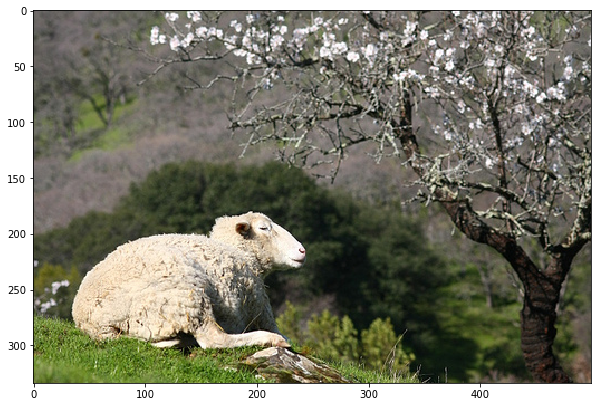

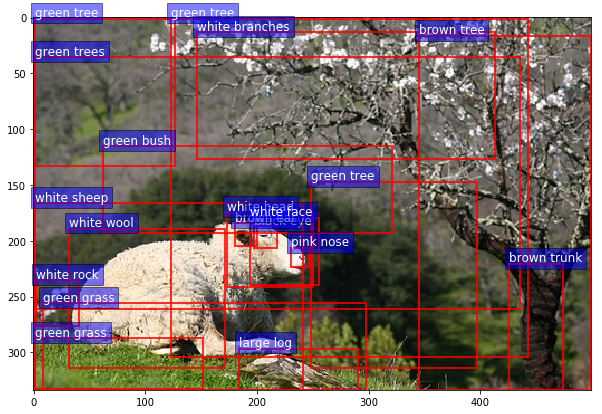

In [10]:
from skimage import io

im_file = caffe_root + 'demo/COCO_val2014_000000273052.jpg' # demo image
im = cv2.imread(im_file)

# You can also try a (more difficult) image from a url, e.g.
#im_bytes = io.imread('https://i.ytimg.com/vi/Y2xDZnLqD5k/maxresdefault.jpg')
#im = cv2.cvtColor(im_bytes, cv2.COLOR_RGB2BGR)

dets = get_detections_from_im(feature_net, im, 0)

rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.figure()
plt.imshow(rgb)
show_features(dets['boxes'], dets['objects'], dets['attrs'])

### 5. Image captioning - top down

In [11]:
# Process
forward_kwargs = lstm_inputs(dets)
caption_net.forward(**forward_kwargs)

# Decoding the unrolled caption net and print beam search outputs
image_ids = caption_net.blobs['image_id'].data
captions = caption_net.blobs['caption'].data
scores = caption_net.blobs['log_prob'].data     
batch_size = image_ids.shape[0]

beam_size = captions.shape[0] / batch_size
print "Beam size: %d" % beam_size
for n in range(batch_size):
    for b in range(beam_size):
        cap = translate(vocab, captions[n*beam_size+b])
        score = scores[n*beam_size+b]
        print '[%d] %.2f %s' % (b,score,cap)

Beam size: 5
[0] -7.63 A sheep laying in the grass next to a tree.
[1] -7.84 A sheep laying on the grass next to a tree.
[2] -7.96 A sheep laying in the grass near a tree.
[3] -8.41 A sheep laying in a field of grass.
[4] -8.46 A sheep laying down in the grass next to a tree.


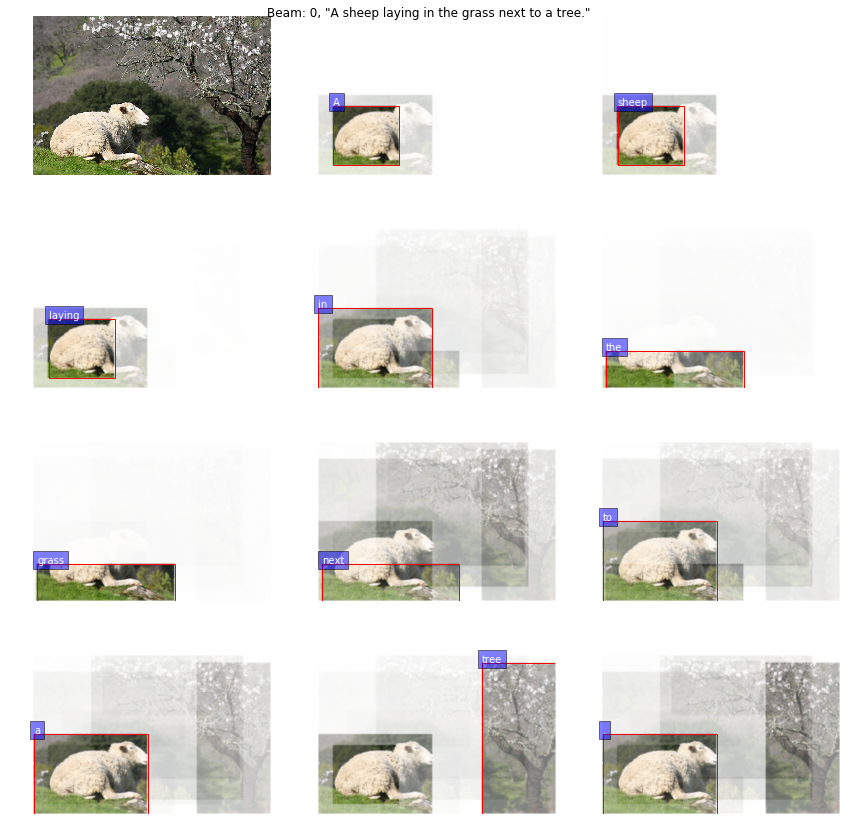

In [12]:
# Visualize one of the beams
beam = 0

cap = translate(vocab, captions[n*beam_size+beam])
attMaps = []
words = []
for t in range(20):
    word_ix = int(captions[beam][t])
    attMap = caption_net.blobs['att_weight_%d' % (t)].data[beam].flatten()[:dets['num_boxes']]
    attMaps.append(attMap)
    words.append(translate(vocab, [word_ix]))
    if t > 0:
        words[-1] = words[-1].lower()
    if word_ix == 0:
        break       
title = 'Beam: %d, "%s"' % (beam,cap)
showAttMapClear(rgb, attMaps, dets['boxes'], words, title, width=3)